# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

[Шаг 1. Подготовка данных](#Шаг_1)

[Шаг 2. Обучение моделей](#Шаг_2)

[Шаг 3. Анализ качества моделей](#Шаг_3)

<a id='Шаг_1'></a>

# <font color='purple'> ШАГ 1. Подготовка данных</font>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

<div class="alert alert-success">
Молодец, что группируешь все импорты в одном месте, такая структуризации полезна и удобна
</div>

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.sample(n=5,random_state=12345)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Для вариативности полезно использовать метод sample с зафиксированным random_state, тогда будут выдаваться случайные строки. Иначе выдача последовательных строк может создать ложное впечатление о датасете, например
</div>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


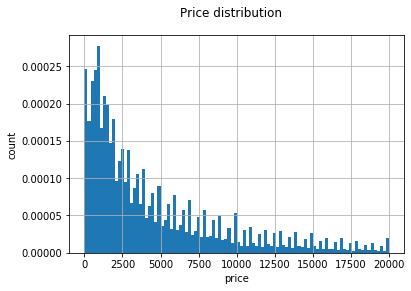

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [6]:
ax = data['Price'].hist(density=True,bins=100)
ax.set_xlabel('price')
ax.set_ylabel('count')
plt.suptitle('Price distribution')
plt.show()
data['Price'].describe()

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Не хватает подписей и легенды у графиков</div>

<font color='blue'> <b> Комментарий студента V1. </b>
    Увидела ниже коммент про цену = 0. считаю, что ее можно удалить. Также заметила большое количество машин ценой даже менбше 10 евро, соответственно, встает вопрос, какую цену считать оптимальной для автомобиля?
Я посчитала нужным удалить нулевые Power и RegistrationMonth, если они совпали с ценой меньше 10, потому что предполагаю,что данные просто не были заполнены корректно. Также я удалила странно мощные машины и машины, у которых слишком низкая цена для указанной высокой мощности. Также удалила странно низкую мощность. 

In [7]:
data[data['Price']==0].count()

DateCrawled          10772
Price                10772
VehicleType           7032
RegistrationYear     10772
Gearbox               8294
Power                10772
Model                 8588
Kilometer            10772
RegistrationMonth    10772
FuelType              7336
Brand                10772
NotRepaired           5484
DateCreated          10772
NumberOfPictures     10772
PostalCode           10772
LastSeen             10772
dtype: int64

In [8]:
data.drop(data[(data['Price']<10) & (data['Power']==0)].index, inplace=True)

In [9]:
data.drop(data[(data['Price']<10) & (data['RegistrationMonth']==0)].index, inplace=True)

<div class="alert alert-success">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
Да, молодец. Вообще полезно было бы посмотреть на их графики, тогда примерно понятно будет, что можно отсечь с двух концов. А, вижу ниже графики, молодец;)</div>

In [10]:
data.drop(data[(data['Power']>1000) & (data['Price']<10000)].index, inplace=True)

In [11]:
data.drop(data[data['Power']>1600].index, inplace=True)

In [12]:
data.drop(data[data['Power']<20].index, inplace=True)

In [13]:
data.drop(data[data['Price']==0].index, inplace=True)

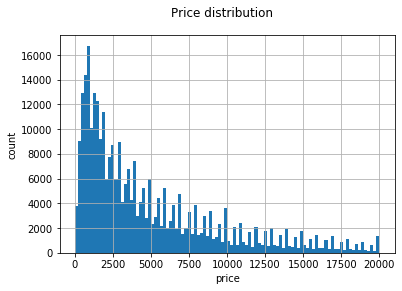

count    306357.000000
mean       4815.056209
std        4588.067624
min           1.000000
25%        1300.000000
50%        3100.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

In [14]:
ax = data['Price'].hist(bins=100,range=(0,20000))
ax.set_xlabel('price')
ax.set_ylabel('count')
plt.suptitle('Price distribution')
plt.show()
data['Price'].describe()

In [15]:
#тут я еще построила ящики с усами, чтобы было виднее оставшиеся хвосты. все-таки решила их оставить.

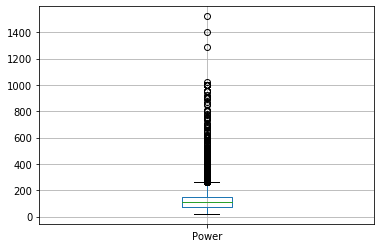

In [16]:
data.boxplot(column=['Power'])

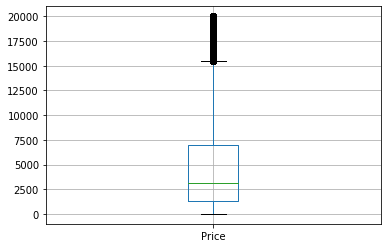

In [17]:
data.boxplot(column=['Price'])

<font color='blue'> <b> Комментарий студента V2. </b>
    Также я удалила объявления со странными годами регистрации, колонки LastSeen и DateCrawled.

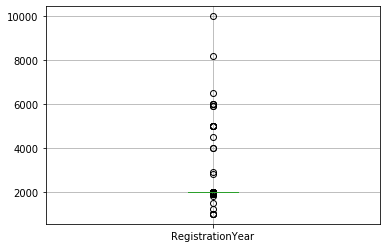

In [18]:
data.boxplot(column=['RegistrationYear'])

In [19]:
data.drop(data[data['RegistrationYear']>2021].index, inplace=True)

In [20]:
data.drop(data[data['RegistrationYear']<1910].index, inplace=True)

In [21]:
pd.to_datetime(data['DateCrawled'])

1        2016-03-24 10:58:45
2        2016-03-14 12:52:21
3        2016-03-17 16:54:04
4        2016-03-31 17:25:20
5        2016-04-04 17:36:23
                 ...        
354361   2016-03-09 13:37:43
354362   2016-03-19 19:53:49
354366   2016-03-05 19:56:21
354367   2016-03-19 18:57:12
354368   2016-03-20 19:41:08
Name: DateCrawled, Length: 306331, dtype: datetime64[ns]

In [22]:
pd.to_datetime(data['DateCreated'])

1        2016-03-24
2        2016-03-14
3        2016-03-17
4        2016-03-31
5        2016-04-04
            ...    
354361   2016-03-09
354362   2016-03-19
354366   2016-03-05
354367   2016-03-19
354368   2016-03-20
Name: DateCreated, Length: 306331, dtype: datetime64[ns]

In [23]:
pd.to_datetime(data['LastSeen'])

1        2016-04-07 01:46:50
2        2016-04-05 12:47:46
3        2016-03-17 17:40:17
4        2016-04-06 10:17:21
5        2016-04-06 19:17:07
                 ...        
354361   2016-03-13 01:44:13
354362   2016-03-19 20:44:43
354366   2016-03-11 18:17:12
354367   2016-04-07 07:15:26
354368   2016-03-24 12:45:21
Name: LastSeen, Length: 306331, dtype: datetime64[ns]

In [24]:
data = data.fillna('unknown')

<font color='blue'> <b> Комментарий студента V3. </b>
    К удаляемым добавила столбцы с количеством фоток и с датой создания. Добавила удаление дублей.

In [25]:
data.drop(['LastSeen', 'DateCrawled', 'NumberOfPictures', 'DateCreated'], axis=1, inplace=True)

In [26]:
data.drop_duplicates(inplace=True)

In [27]:
data.duplicated().sum()

0

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Ты тут, кстати, не удалила, в итоге, у тебя inplace=True не стоит</div>

Комментарий студента - исправила

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
По идее PostalCode может быть полезен, как мне кажется, указывает локацию, откуда продается </div>

<div class="alert alert-danger">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
А что по поводу DataCreated и NumberOfPictures? Ведь тоже бесполезные фичи, если подумать</div>

<div class="alert -info">
<h1>Комментарий студента <a class="tocSkip"></a></h1>
Я оставляю DateCreated и NumberOfPictures, с PostalCode тоже соглашусь, надо оставить.

Но у меня вопрос все же по столбцам с датами, как с ними обходиться, если не пользоваться кодировщиками OHE или OrdinalEncoder?</div>

<div class="alert alert-info">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
1) NumberOfPictures --- константный признак, он ни на что не влияет

2) Ну ты во-первых,  можешь вычленить год, месяц, число .. и т.д, которые можно уже легко закодировать. Можно также выбрать какую-то дату, например 1910 год и сделать новый признак --- кол-во дней с 1910 года.  
    
3) А как может влиять Дата создания объявления на стоимость машины?

</div>

In [28]:
# data = data.drop(columns=['PostalCode', 'DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures'])
# data = pd.get_dummies(data,columns=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired'])
# target = data['Price']
# features = data.drop(['Price'], axis=1)

# features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4,random_state=12345)
# model2 = LinearRegression()
# model2.fit(features_train, target_train)
# predicted_train2=model2.predict(features_train)
# predicted_valid2=model2.predict(features_valid)
# print(mean_squared_error(predicted_train2,target_train)**0.5)
# print(mean_squared_error(predicted_valid2,target_valid)**0.5)

In [29]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [30]:
data_ohe.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
count,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,...,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000,287154.000000
mean,4775.434941,2003.272310,120.280835,128659.969912,5.948599,51355.812749,0.061002,0.047988,0.008212,0.270635,...,0.015180,0.005736,0.002201,0.006627,0.013634,0.000992,0.218050,0.009270,0.156662,0.099048
std,4579.153719,6.959546,54.819859,36556.382096,3.601024,25777.652694,0.239335,0.213742,0.090245,0.444289,...,0.122269,0.075516,0.046862,0.081137,0.115965,0.031488,0.412922,0.095835,0.363482,0.298727
min,1.000000,1910.000000,20.000000,5000.000000,0.000000,1067.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,30989.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3000.000000,2003.000000,110.000000,150000.000000,6.000000,50321.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6900.000000,2008.000000,150.000000,150000.000000,9.000000,72202.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20000.000000,2019.000000,1521.000000,150000.000000,12.000000,99998.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# encoder = OrdinalEncoder()
# data = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

enc = OrdinalEncoder()
cols = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
data[cols] = enc.fit_transform(data[cols])

<div class="alert alert-danger">
<h1>Комментарий ревьюера v4 <a class="tocSkip"></a></h1>
Закомментил твой участок кода. Понимаешь в чем разница? 

Подсказка: Как будет работать <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html'>OrdinalEncoder</a>, если ты его применишь ко всему датасету?
</div>

<span style='background:yellow'><font color='blue'> <b> Комментарий студента V4. </b>
    Ну да, логично, зачем нам менять фичи с уже числовыми данными.</span>

<div class="alert -info">
<h1>Комментарий студента <a class="tocSkip"></a></h1>
Да, уидела ошибку, исправляю</div>

<div class="alert alert-danger">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
А подходит ли данный метод кодирования  при использовании линейной регрессии?</div>

<div class="alert alert-danger">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
А какие столбцы? Ниже привел пример того, что новых столбцов не появилось</div>

<font color='blue'> <b> Комментарий студента V3. </b>
    Я не понимаю, в "Обучении с учителем" мы применяли данный метод ко всему датасету. Как надо-то?

<div class="alert alert-success">
<h1>Комментарий ревьюера v4<a class="tocSkip"></a></h1>
В обучении с учителем вы пытались поделить всю выборку на кластеры (если правильно понимаю, о каком  проекте идет речь) (т.е пытались кластеризовать данные). Потом уже, найдя такие кластеры, мы можем обучить классификатор, который для какого-то входного объекта будет говорить, к какому кластеру он принадлежит.

Здесь же мы хотим обучить нашу модель на обучающей выборке,а затем протестировать ее качество на скрытых данных (тестовых), чтобы потом, например, применять в продакшене на сервисе. Поэтому в данном случае мы не можем обучать сразу на всех данных наши модели (в том числе standartScaler, ведь мы не имеем доступа к скрытым данным)
</div>

<div class="alert alert-success">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
Упустил, стоило еще проверить на дубликаты</div>

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Молодец, хорошая идея произвести масштабирование!</div>

Категориальные данные все привели к цифровому формату, провели процедуру масштабирования.

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Не хватает обработки выбросов, потому что они могут повлиять на результат. Например, просмотр основных статистик тебе покажет, что есть машина с годом регистрации 1000, а есть  Power огромный несуществующий... И так далее:)
    
    Советую глянуть основные статистики датасета;)
    </div>

<font color='blue'> <b> Комментарий студента V2. </b>
    А просмотр всех статитстик датасета имеется ввиду по каждой фиче строить график и смотреть статистику? правильно?

<div class="alert alert-info">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
Ну, метод describe хотя бы:)
</div>

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Что по поводу нулевой стоимости машин:)?
</div>

<a id='Шаг_2'></a>

# <font color='puple'> ШАГ 2. Обучение моделей

In [32]:
target = data['Price']
features = data.drop(['Price'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.4,random_state=12345)

In [33]:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid,
                                                                            test_size=0.25,random_state=12345)

<div class="alert alert-success">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
DATA LEAKAGE DETECTED.  У тебя тестовая и валидационная выборка входят в обучающую. Будь вниматльнее:)
</div>

<font color='blue'> <b> Комментарий студента V3. </b>
    Да, спасибо! исправила.

In [34]:
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop(['Price'], axis=1)
features_ohe_train, features_ohe_valid, target_ohe_train, target_ohe_valid = train_test_split(features_ohe, target_ohe,
                                                                                              test_size=0.25,random_state=12345)

In [35]:
features_ohe_valid, features_ohe_test, target_ohe_valid, target_ohe_test = train_test_split(features_ohe_valid,
                                                                                            target_ohe_valid,
                                                                                            test_size=0.25,random_state=12345)

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Я бы все-таки советовал бы разбивать на 3 выборки: тестовую, валидационную и обучаюшую:)</div>

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(features_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Подумай, адекватна ли глубина больше 100?  Готов поспорить там как минимум будет дерево максимально переобученное</div>

In [39]:
def learning (model,features_train,features_valid,features_test,target_train,target_valid,target_test):
    model.fit(features_train,target_train)
    predicted_train=model.predict(features_train)
    predicted_valid=model.predict(features_valid)
    predicted_test=model.predict(features_test)
    print('TRAIN', mean_squared_error(target_train,predicted_train)**0.5)
    print('VALID', mean_squared_error(target_valid,predicted_valid)**0.5)
    print('TEST', mean_squared_error(target_test,predicted_test)**0.5)

<div class="alert alert-danger">
<h1>Комментарий ревьюера v4 <a class="tocSkip"></a></h1>
Только у тебя видимо опечатка, в модель надо добавить аргументы датасетов,..., иначе у тебя сейчас не на ohe обучается регрессия, а на  features_train, features_valid ...
</div>

<div class="alert alert-warning">
<h1>Комментарий ревьюера v4<a class="tocSkip"></a></h1>
Странная строчка: model = model :)</div>

<div class="alert alert-success">
<h1>Комментарий ревьюера v4<a class="tocSkip"></a></h1>
Во, теперь огонь:) Осталось чуть поправить:)</div>

In [46]:
%%time
learning(RandomForestRegressor(n_estimators=90,max_depth=20,random_state=12345),
         features_train,features_valid,features_test,
         target_train,target_valid,target_test)

TRAIN 799.4495329399672
VALID 1659.169161826238
TEST 1632.915020401286
CPU times: user 1min 22s, sys: 304 ms, total: 1min 23s
Wall time: 1min 24s


In [41]:
scaler.fit(features_ohe_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [43]:
features_ohe_train = scaler.transform(features_ohe_train)
features_ohe_valid = scaler.transform(features_ohe_valid)
features_ohe_test = scaler.transform(features_ohe_test)

In [44]:
%%time
learning(LinearRegression(),
         features_ohe_train,features_ohe_valid,features_ohe_test,
         target_ohe_train,target_ohe_valid,target_ohe_test)

TRAIN 2614.780689428986
VALID 2600.7855712699907
TEST 2602.754817398814
CPU times: user 18.7 s, sys: 5.76 s, total: 24.4 s
Wall time: 24.5 s


<div class="alert alert-info">
<h1>Комментарий ревьюера  v2<a class="tocSkip"></a></h1>
Стало много кода, который, как я вижу, тяжелее редактировать, да и читаемость становится хуже. Тут полезно было бы завести отдельную функцию, в которой был бы общий код:) Дабы не дублировать функциональность:)</div>

<font color='blue'> <b> Комментарий студента V2. </b>
    А подскажи, плз, что показывает этот coef_? Почитала, что это у нас b1 для каждого признака. но что говорят именно сами цифры? какими они должны быть?что-то не оч понятно

In [ ]:
# model2.coef_

<div class="alert alert-info">
<h1>Комментарий ревьюера  v2<a class="tocSkip"></a></h1>
Ну у тебя как считается результат: $x_1*coef_1.+ ...coef_i* x_i$. Соответственно, если у тебя вес в районе нуля, то модель этот признак не использует по факту в расчетах (он не влияет на финальный результат).
    
Например, здесь это коэф 1.42108547e-14, который относится как раз таки DataCreated:))    
</div>

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Советую посмотреть на веса модели через метод coef --- будет полезно;)
</div>

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Вроде как мы решили, что эти признаки и не нужны для модели?</div>

<font color='blue'> <b> Комментарий студента V1. </b>
    Плюс я совсем запуталась с lgb, в документации написано, что ему можно подавать категориальные переменные, задав для них отдельный список, однако, потом вылазит ошибка именно категориальных переменных. Также есть инфа в инете, что в lgb на самом деле нужно подавать уже преобразованные в int категориальные переменные...

In [42]:
cat_features = ['VehicleType', 'Gearbox',
                'Model', 'FuelType', 'Brand', 'NotRepaired']

<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Ты про LGBMRegressor регрессор? Ну привести к category: astype(cat) . Если правильно понял твой вопрос
</div>

In [43]:
train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=cat_features)
valid_data = lgb.Dataset(features_valid, label=target_valid)
test_data = lgb.Dataset(features_test, label=target_test)

In [44]:
parameters = {
    
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [45]:
%%time
bst = lgb.train(parameters, train_data, valid_sets=valid_data)
predictions = bst.predict(features_valid)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


CPU times: user 56 s, sys: 32.7 ms, total: 56 s
Wall time: 56.5 s


In [46]:
%%time
predictions_test = bst.predict(features_test)

CPU times: user 469 ms, sys: 0 ns, total: 469 ms
Wall time: 497 ms


In [47]:
print(mean_squared_error(target_valid,predictions)**0.5)
print(mean_squared_error(target_test,predictions_test)**0.5)

1710.6490990750506
1685.719467842759


<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Получаются подозрительно хорошие модели, пока не нашел, ошибку, но после твоих исправлений в след итерации еще раз детально посмотрю
    </div>

<div class="alert alert-danger">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
Фуф, это было нелегко, но я нашел! 
    
    1)Смотри, ты обучаешь scaler на всей выборке, но ведь так нельзя делать! Мы ведь не можем обучаться на данных, которых не знаем (тестовые данные)
    
    2) DATA LEAKAGE DETECTED.  У тебя тестовая и валидационная выборка входят в обучающую. Будь внимательнее:) Поэтому такие идеальные варианты
    </div>

<font color='blue'> <b> Комментарий студента V3. </b>
    ВСе сделала как ты сказал, плюс попыталась привести в удобочитаемый вид. Написала функцию для моделей - линейная регрессия теперь отрпабатывает и дает ужасающий результат на тестовой выборке. 
    У меня теперь снова вопрос по Light GBM, смотри для того чтобы обучить его, я снова разбиваю данные на валидационную и тренинговую выборки. Если этого не делать, т.е. пользоваться теми данными, что мы разбили раньше, почему-то выдается ошибка.Правильно ли так делать? и еще вопрос про тестовую выборку, здесь тоже лучше разбивать на три части?
   

<div class="alert alert-danger">
<h1>Комментарий ревьюера v4 <a class="tocSkip"></a></h1>
1) Ужасающий результат: А это потому что ты забыла через масштабирование признаков пропустить тестовые данные:) (transform забыла)
    
2)  Аналогично 3 вопросу:)  А что именно за ошибку? Обычно природа ошибки становится сразу понятна, если посмотреть детали ошибки (вывод)    
    
3) Про разбитие тестовой на три части не совсем понял:) Ну стандартно у тебя 60:20:20 (обучающая, валид, тест). Если данных очень много то тестовую часть делают еще меньше.  А зачем тестовую еще дальше делить?)
        </div>

<span style='background:yellow'><font color='blue'> <b> Комментарий студента V4. </b>
    1) После замечания я пропустила через масштабирование тестовые признаки тоже, но результат также ужасающий.
    2) Теперь все работает.. не знаю, глюк был какой-то
    3) Нене, там все было к той же выскаивающей ошибке, вопрос снят.
    </span>

<div class="alert alert-success">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
Тогда с тебя правки того, что выше + приведи код в читаемый вид, а то сейчас очень сумбурно выглядит, я даже запустить не смог полностью:)
    
Вроде ответил на все вопросы что увидел. Лучше их также в комментарии оформляй, тогда их точно не пропустить;)
    
Я в тебя верю:)
</div>

<a id='Шаг_3'></a>

# <font color='purple'> ШАГ 3. Анализ моделей</font>

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Круто было бы иметь финальную табличку, было бы наглядно:)
</div>

In [ ]:
#финальную табличку сравнения моделей?

<div class="alert alert-info">
<h1>Комментарий ревьюера v2 <a class="tocSkip"></a></h1>
Yeap
</div>

<font color='blue'> <b> Комментарий студента V2. </b>
    Итак, качество модели даже без подбора лучших параметров лучше у RandomForest, хотя по скорости это самая медленная модель. 
LightGBM работает гороаздо быстрее, но на тестовой выборке показал какой-то совсем плохой вариант. 

<div class="alert alert-success">
<h1>Комментарий ревьюера v4<a class="tocSkip"></a></h1>
Думаю, мы на финишной прямой, осталось поправить последние красные замечания под версией v4.
В остальном, стало намного лучше:) Остался маленький шажок!

</div>

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Еще можно было бы реализовать дамми модель для сравнения
</div>

<div class="alert alert-success">

<h1>Комментарий ревьюера v5 <a class="tocSkip"></a></h1>
Ура, успех!
</div>

## Чек-лист проверки

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

-Спасибо за качественно сделанный проект, было приятно проверять. 

- Видно, что приложено много усилий

- Код написан хорошо 

- Соблюдена структура проекта 
    
- Также оставил пару замечаний и советов

- К сожалению есть пара критических замечаний, которые нужно поправить. Будут вопросы - пиши;)

C нетерпением жду твоих исправлений!:)

</div>

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей